In [1]:
# PDO from SST data

In [36]:
%matplotlib inline

import os
import time
import datetime as dt 

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from mpl_toolkits.basemap import Basemap

import netCDF4 as nc

from six.moves import urllib # six is for Python 2/3 compatibility

from pycurrents.codas import to_day
from pycurrents.num import rangeslice
from pycurrents.num import eof
# https://currents.soest.hawaii.edu/ocn_data_analysis/installation.html

In [50]:
fnames = ['sst_ocean_1950_2150_north_pacific.nc', 'lsmask_remap_north_pacific.nc']
        
lsmasknc = nc.Dataset(fnames[1])

# strip the time dimension off the mask
seamask = lsmasknc.variables['mask'][0].astype(bool)
lsmasknc.close()
landmask = np.logical_not(seamask)
print(landmask.shape)

sstnc = nc.Dataset(fnames[0])

# Read all the 1-D dimensional arrays.
time = sstnc.variables['time'][:]
lat = sstnc.variables['lat'][:]                       
lon = sstnc.variables['lon'][:]

# Read the 3-D SST array, and mask it.
sst = np.ma.array(sstnc.variables['sst'][:])
sst[:, landmask] = np.ma.masked
sstnc.close()
def yearly_time_axis(dvolc, verbose=True):
    """
    Generates time axis for yearly data 
    """
    Nt = len(dvolc)
    time = [dt.datetime(1950, 1, 15)]
    for i in range(1, len(dvolc)):
        y = time[i - 1].year
        y += 1
        time.append(dt.datetime(y, 1, 15))
    time = np.array(time)

    return time
yeartime = yearly_time_axis(time)
#print(yeartime)

(51, 161)


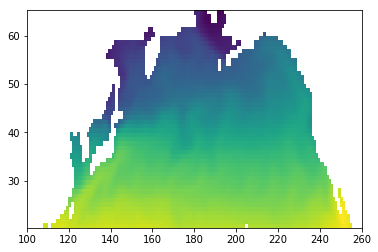

In [13]:
# Quick plot of on month against indices (sanity check).
plt.pcolormesh(lon,lat,sst[10])

In [14]:
sstmean = sst.mean(axis=0)
sstdm = sst - sstmean

sstdmz = sstdm.filled(0)


In [15]:
latweights = np.sqrt(np.cos(np.deg2rad(lat)))
latweights = latweights[np.newaxis, :, np.newaxis]
sstdmz *= latweights

In [16]:
ssteof = eof.EOF(sstdmz)

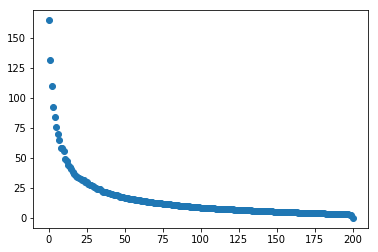

In [17]:
fig, ax = plt.subplots()
ax.plot(ssteof.s, 'o')
ax.margins(0.05)

In [18]:
pats = np.ma.array(ssteof.v_reshaped)
pats[:, landmask] = np.ma.masked
pats /= latweights
pats = pats *  ssteof.s[:, np.newaxis, np.newaxis]

In [19]:
cmap = plt.get_cmap('RdBu_r')

In [20]:
# quick and dirty: using global pats and ssteof
def contour_pattern(i):
    # normalize so that std of time function is unity, and pattern
    # is in degrees.
    std_t = ssteof.u[:, i].std()
    pat = pats[i] * std_t
    mag = pat.std()
    cticker = mpl.ticker.MaxNLocator(nbins=30, symmetric=True)
    cticker.create_dummy_axis()
    cticker.set_bounds(-2*mag, 2*mag)
    clevs = cticker()

    fig, ax = plt.subplots()
    cs = ax.contourf(lon, lat, pat, levels=clevs,
                 cmap=cmap,
                 extend='both')
    ax.patch.set_facecolor('gray')
    fig.colorbar(cs, ax=ax, shrink=0.9)

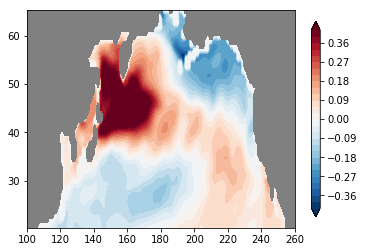

In [23]:
contour_pattern(0)

In [24]:
gmap = Basemap(lon_0=180, projection="kav7", resolution='c')
X, Y = gmap(*np.meshgrid(lon, lat))
def draw_map(gmap, ax):
    gmap.drawmapboundary(ax=ax)
    gmap.drawcoastlines(ax=ax)
    gmap.fillcontinents(ax=ax)
    gmap.drawmeridians(np.arange(0, 360.01, 30), ax=ax)
    gmap.drawparallels(np.arange(-60, 60.01, 30), ax=ax)

In [48]:
def map_pattern(i, pats, ssteof, yeartime, gmap):
    # normalize so that std of time function is unity, and pattern
    # is in degrees.
    std_t = ssteof.u[:, i].std()
    pat = pats[i] * std_t
    mag = pat.std()
    cticker = mpl.ticker.MaxNLocator(nbins=30, symmetric=True)
    cticker.create_dummy_axis()
    cticker.set_bounds(-2*mag, 2*mag)
    clevs = cticker()

    #fig, ax = plt.subplots()
    #cs = ax.contourf(lon, lat, pat, levels=clevs,
    #             cmap=cmap,
    #             extend='both')
    #fig.colorbar(cs, ax=ax, shrink=0.9)

    fig, axs = plt.subplots(nrows=2, figsize=(7, 10))
    
    draw_map(gmap, ax=axs[1])
    cs = gmap.contourf(X, Y, pat, levels=clevs, 
                   cmap=cmap,
                   extend='both', ax=axs[1])
    cbar = fig.colorbar(cs, ax=axs[1], orientation='vertical',
                        shrink=0.8,
                        ticks=plt.MaxNLocator(nbins=6, symmetric=True))
    cbar.set_label('$^\circ$C')
    ax = axs[0]
    ax.plot(yeartime, ssteof.u[:, i] / std_t)
    ax.set_title("EOF %d: %.1f%% of variance" % 
                 (i, ssteof.percent_var()[i]))
    np.savetxt('pc'+str(i)+'.txt', ssteof.u[:, i] / std_t, delimiter=",")

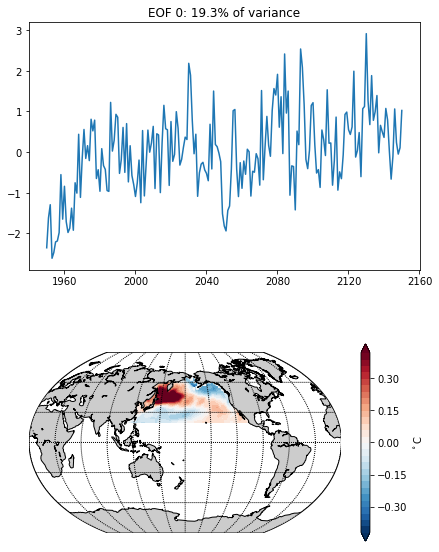

In [51]:
map_pattern(0, pats, ssteof, yeartime, gmap)

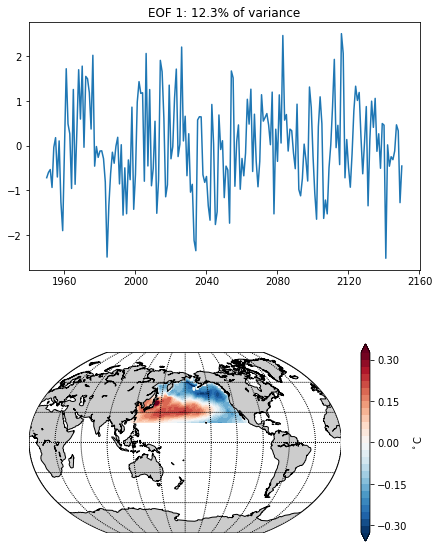

In [52]:
map_pattern(1, pats, ssteof, yeartime, gmap)